In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Emotion Recognition Training:**

In order to perform Emotion detection, the Convolutional Neural Network Model is used to train fer2013 dataset. This file contains the following tasks:


*   Downloading the Dataset and Analysing it
*   Building the CNN Model for Emotion Detection
*   Training the CNN Model
*   Testing the model and saving the trained model as a JSON file.



In [2]:
import pandas as pd
import numpy as np


from keras import backend as K

# for the architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D

# optimizer, data generator and learning rate reductor
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Downloading and Analysing the DataSet**

The fer2013 is an open-source dataset. It has 48x48 pixel grayscale images of faces. The dataset is divided into three categories:
* training set
* validation set (Public Testing)
* test set (Private Testing)

To analyze the data set, first load the downloaded dataset using Pandas. The dataset has seven categories of Emotions - (0 - Angry, 1 - Disgust, 2 - Fear, 3 - Happy, 4 - Sad, 5 - Surprise and 6 - Neutral). It can be visualized using sarborn and matplotlib modules.

In [4]:
emotion_data = pd.read_csv('/content/drive/My Drive/ER_training/fer2013.csv')
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [5]:
emotion_data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = emotion_data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
print(emotion_counts)

# mean and std
cls_mean = np.mean(emotion_counts['number'])
cls_std = np.std(emotion_counts['number'],ddof=1)
if cls_std > cls_mean * (0.6827 / 2):
    print("The standard deviation is high")

print("The mean amount of elements per class is", cls_mean)
print("The standard deviation in the element per class distribution is", cls_std)


    emotion  number
0     Angry    4953
1    Digust     547
2      Fear    5121
3     Happy    8989
4       Sad    6077
5  Surprise    4002
6   Neutral    6198
The standard deviation is high
The mean amount of elements per class is 5126.714285714285
The standard deviation in the element per class distribution is 2557.242050483666


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


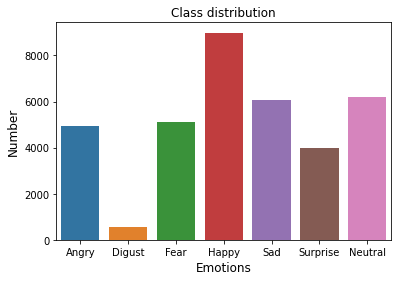

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

The 'Disgust' class has very less training examples and also the standard deviation too high. Let's plot images from each class to better visualise data further,

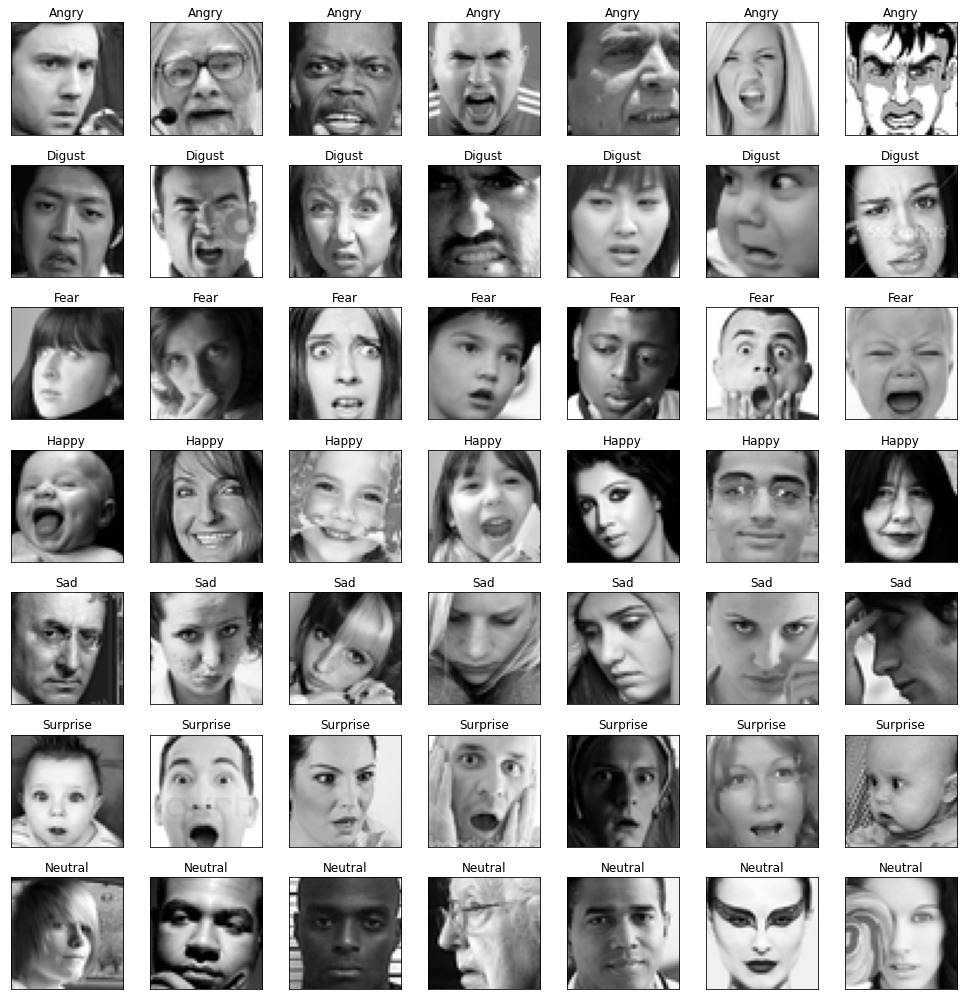

In [8]:
fig = plt.figure(1,(14,14))

k = 0
for label in sorted(emotion_data.emotion.unique()):
  for j in range(7):
    px = emotion_data[emotion_data.emotion == label].pixels.iloc[k]
    px = np.array(px.split(' ')).reshape(48,48).astype('float32')
    k += 1
    ax = plt.subplot(7,7,k)
    ax.imshow(px,cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_map[label])
    plt.tight_layout()


The images in class 'Disgust' and very similar to 'Anger'. So, we can safely rename labels of all images in 'Disgust' as 'Anger'.

In [9]:
emotion_data['emotion'].replace(to_replace = {0:0,1:0,2:1,3:2,4:3,5:4,6:5},inplace = True)
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            1  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            5  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        5  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        2  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        2  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        1  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


Now, again plot the distribution of data points and calculate mean and standard deviation.

    emotion  number
0     Angry    5500
1      Fear    5121
2     Happy    8989
3       Sad    6077
4  Surprise    4002
5   Neutral    6198
The mean amount of elements per class is 5981.166666666667
The standard deviation in the element per class distribution is 1672.8281940075815


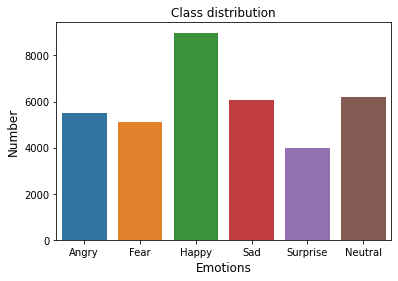

In [10]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}
emotion_counts = emotion_data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
print(emotion_counts)

# mean and std
cls_mean = np.mean(emotion_counts['number'])
cls_std = np.std(emotion_counts['number'],ddof=1)
if cls_std > cls_mean * (0.6827 / 2):
    print("The standard deviation is high")

print("The mean amount of elements per class is", cls_mean)
print("The standard deviation in the element per class distribution is", cls_std)

plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [11]:
emotion_data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

Now, the standard deviation is not too high and all classes can be considered to be distributed evenly.

**Assigning Training and Validation Sets**

The data is then split into training, validation and test sets. In order to train images on the model, they are reshaped in the format [n$_h$, n$_w$, n$_c$]. As the images in dataset are in grayscale, the number of channels (n$_c$) is 1 and since the dimension of the image is 48 pixels, n$_h$ = n$_w$ = 48.

Once the samples are reshaped, the training, validation and testing labels are converted into categorical format. The labels vary in the range from [0 - 6] and the type of loss defined for CNN model further is of categorical_crossentropy. Hence, the labels should be in the categorical format (one-hot encoding).
For Example, if the first four values of Y_train are:

Index , Label

0 , 2

1 , 3

2 , 0

3 , 5

Then, After one-hot encoding, the Y_train will appear as follows:

Index , Label

0 , [0,0,1,0,0,0,0]

1 , [0,0,0,1,0,0,0]

2 , [1,0,0,0,0,0,0]

3 , [0,0,0,0,0,1,0]




In [12]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []
for index, row in emotion_data.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
      X_train.append(np.array(k))
      y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
      X_val.append(np.array(k))
      y_val.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
      X_test.append(np.array(k))
      y_test.append(row['emotion'])

In [13]:
from keras.utils import np_utils
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')

# One-hot Encoding
y_train= np_utils.to_categorical(y_train, num_classes=6)
y_val = np_utils.to_categorical(y_val, num_classes=6)
y_test = np_utils.to_categorical(y_test, num_classes=6)

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((28709, 48, 48, 1),
 (28709, 6),
 (3589, 48, 48, 1),
 (3589, 6),
 (3589, 48, 48, 1),
 (3589, 6))

**Sample Images Visualisation**

The images in training and validation test can be visualised using imshow function of matplotlib. 

y =  [0. 0. 1. 0. 0. 0.]


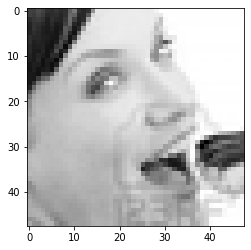

In [15]:
index = 34
plt.imshow(X_train.reshape(28709,48,48)[index], cmap = 'gray')
print('y = ',str(np.squeeze(y_train[index])))
#EMOTIONS = ["angry","scared", "happy", "sad", "surprised","neutral"]

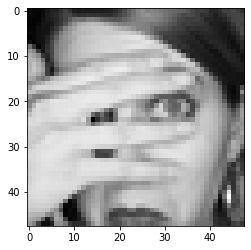

In [16]:
index = 68
plt.imshow(X_val.reshape(3589,48,48)[index], cmap = 'gray')

**Building CNN Model**

The Architecture of The CNN model for training is:

In -> [ [CONV2D -> ReLU -> BatchNorm]*2 -> MAXPOOL ] * 4 -> FLATTEN -> DENSE -> Out

* For the CONV2D layers, usually less number of filters are taken initially, and the number increases as we move deeper in the network. 
* The filter size/ kernel size is taken as (3,3). 
* The padding is kept 'same' so that the size of image remains the same and doesn't shrink after convolution. 
* The MAXPOOL2D is mainly used in order to reduce the variance (overfitting) as it extracts the most important features (like edges) and reduces the computational complexity as it makes the image smaller.
* L2 Regularization is added in the DENSE layers to avoid high variance. 

The summary of the model displays all layers along with the output shapes and number of parameters in it. 





In [17]:
from keras import regularizers
model = Sequential()

dim = 48
nclasses = 6

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(dim,dim,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(nclasses, activation='softmax'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



**Compiling the Model**



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 128)      

**Compiling The Model**

*   **Optimizer** : The 'sgd' optimizer or the Gradient Descent (with momentum) optimizer is used to minimize the cost function. The default learning rate is 0.01 . 
*   **Loss Function** : It is a measure of overall loss in the network after the parameters are assigned during the forward propagation. It indicated how well the parameters were choosen. It requires the labels to be encoded as one-hot encodings.
*   **Metrics** : It refers to which metric the network should achieve, the most common one is 'accuracy' .



In [18]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

**Other Parameters**



*   **Early Stopping** : It is a form of regularization to avoid overfitting of data. This callback will stop the training if there is no improvement in the validation loss or when there is degradation in the validation loss. 
*   **Data Augmentation** : It is a technique to make the dataset bigger artificially. The most common ways of doing it including rotating images, zooming in small size and shifting images horizontally and vertically.
* **ReduceLROnPlateau** : Reduces learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.



In [19]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [20]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

In [21]:
datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=10,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

datagen.fit(X_train)

In [22]:
epochs = 20
batch_size = 32

**Fit the Model**

Since there is data augmentation, the fitting function changes from fit (when there is no data augmentation) to fit_generator. 

In [23]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(X_val,y_val),
                              verbose=1, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[es,lr_reduction])


Epoch 1/20
897/897 [==============================] - 29s 32ms/step - loss: 24.4639 - accuracy: 0.2946 - val_loss: 20.4722 - val_accuracy: 0.3622
Epoch 2/20
897/897 [==============================] - 22s 24ms/step - loss: 17.4216 - accuracy: 0.3914 - val_loss: 14.9163 - val_accuracy: 0.3123
Epoch 3/20
897/897 [==============================] - 22s 24ms/step - loss: 12.5166 - accuracy: 0.4558 - val_loss: 10.6575 - val_accuracy: 0.4564
Epoch 4/20
897/897 [==============================] - 22s 24ms/step - loss: 9.0866 - accuracy: 0.5013 - val_loss: 7.7485 - val_accuracy: 0.5185
Epoch 5/20
897/897 [==============================] - 22s 24ms/step - loss: 6.6711 - accuracy: 0.5415 - val_loss: 5.7929 - val_accuracy: 0.5183
Epoch 6/20
897/897 [==============================] - 22s 24ms/step - loss: 4.9923 - accuracy: 0.5643 - val_loss: 4.3498 - val_accuracy: 0.5606
Epoch 7/20
897/897 [==============================] - 22s 24ms/step - loss: 3.8064 - accuracy: 0.5857 - val_loss: 3.4597 - val_ac

**Plotting the Loss and Accuracy**

Once the model is trained, the loss and accuracy are plotted in training and validation sets to see its progress over the epochs and detect problems if any. For this particular case, the training loss decreases, which means the network is learning, and there is no substantial difference between the training loss and validation loss wich indicates no overfitting. When the loss is very low (~ 0.96), the accuracy is still just about 70 % indicating that the model has slight high bias. 

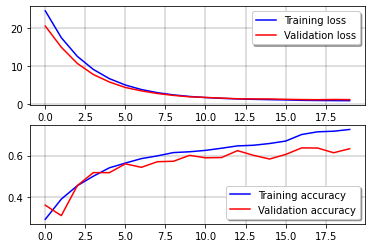

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

**Predict Accuracy on Test Set**

The following is the code to further predict results using the Test dataset and the trained model parameters. Further accuracy can be determined by comparing the predicted results with Test labels.

In [25]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6456


**Test The Model on Test Images of your own**

In [38]:
import cv2

#Load Images to be tested
img1 = cv2.imread('/content/drive/My Drive/ER_training/Emotion_Test/angry_1.jpeg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/drive/My Drive/ER_training/Emotion_Test/fear_1.jpg',cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('/content/drive/My Drive/ER_training/Emotion_Test/happy_1.jpeg',cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('/content/drive/My Drive/ER_training/Emotion_Test/neutral_1.png',cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('/content/drive/My Drive/ER_training/Emotion_Test/sad_1.jpeg',cv2.IMREAD_GRAYSCALE)
img6 = cv2.imread('/content/drive/My Drive/ER_training/Emotion_Test/surprised_1.jpg',cv2.IMREAD_GRAYSCALE)

# Resize and pre-process
dim = (48,48)
img1_resized = cv2.resize(img1,dim, interpolation = cv2.INTER_AREA )
img2_resized = cv2.resize(img2,dim, interpolation = cv2.INTER_AREA )
img3_resized = cv2.resize(img3,dim, interpolation = cv2.INTER_AREA )
img4_resized = cv2.resize(img4,dim, interpolation = cv2.INTER_AREA )
img5_resized = cv2.resize(img5,dim, interpolation = cv2.INTER_AREA )
img6_resized = cv2.resize(img6,dim, interpolation = cv2.INTER_AREA )
imgs = np.array([img1_resized, img2_resized, img3_resized, img4_resized, img5_resized, img6_resized ])
imgs = imgs.reshape(imgs.shape[0],48,48,1)

#True Labels
# correct order - ["angry","scared", "happy", "sad", "surprised","neutral"]
y_true = [0,1,2,5,3,4]

y_predict = np.argmax(model.predict(imgs),axis = 1)
print(y_predict)
print("Accuracy on test image: {:.4f}".format(accuracy_score(y_true, y_predict)))

[0 1 5 5 3 4]
Accuracy on test image: 0.8333


**Save Model and Model Weights**

The model is saved as JSON file and the model weights are saved to and hd5 file. These files can be later accessed to make predictions rather than training the CNN Model again. 

In [39]:
model.save('/content/drive/My Drive/ER_training/Model.h5')
print('Saved Model to Disk')

Saved Model to Disk
